In [5]:
from subprocess import call
import os.path

tfrecord = "/home/fhw/amc/dataset/tfrecord/train-00001-of-01024"
batch_size = 8
tfrecord_idx = "idx_files/train1.idx"
tfrecord2idx_script = "tfrecord2idx"

if not os.path.exists("idx_files"):
    print('aaa')
    os.mkdir("idx_files")

if not os.path.isfile(tfrecord_idx):
    print('bbb')
    call([tfrecord2idx_script, tfrecord, tfrecord_idx])

bbb


In [11]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import nvidia.dali.tfrecord as tfrec
import nvidia.dali.ops as ops
import numpy as np

pipe = Pipeline(batch_size=256, num_threads=6, device_id=0)
with pipe:
    inputs = fn.tfrecord_reader(
        path=tfrecord,
        index_path=tfrecord_idx,
        features={
            "image/encoded" : tfrec.FixedLenFeature((), tfrec.string, ""),
            "image/class/label": tfrec.FixedLenFeature([1], tfrec.int64,  -1),
            "image/class/text": tfrec.FixedLenFeature([ ], tfrec.string, ""),
            "image/object/bbox/xmin": tfrec.VarLenFeature(tfrec.float32, 0.0),
            "image/object/bbox/ymin": tfrec.VarLenFeature(tfrec.float32, 0.0),
            "image/object/bbox/xmax": tfrec.VarLenFeature(tfrec.float32, 0.0),
            "image/object/bbox/ymax": tfrec.VarLenFeature(tfrec.float32, 0.0)})
    jpegs = inputs["image/encoded"]
    images = fn.image_decoder(jpegs, device="mixed", output_type=types.RGB)
    resized = fn.resize(images, device="gpu", resize_shorter=256.)
    output = fn.crop_mirror_normalize(
        resized,
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[0., 0., 0.],
        std=[1., 1., 1.])
    pipe.set_outputs(output, inputs["image/class/text"])

class HybridPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, img_root = tfrecord):
        super(HybridPipeline, self).__init__(batch_size, num_threads, device_id)#, seed = 12
        ori_input = fn.tfrecord_reader(
            path=tfrecord,
            index_path=tfrecord_idx,
            features={
                "image/encoded" : tfrec.FixedLenFeature((), tfrec.string, ""),
                "image/class/label": tfrec.FixedLenFeature([1], tfrec.int64,  -1),
                "image/class/text": tfrec.FixedLenFeature([ ], tfrec.string, ""),
                "image/object/bbox/xmin": tfrec.VarLenFeature(tfrec.float32, 0.0),
                "image/object/bbox/ymin": tfrec.VarLenFeature(tfrec.float32, 0.0),
                "image/object/bbox/xmax": tfrec.VarLenFeature(tfrec.float32, 0.0),
                "image/object/bbox/ymax": tfrec.VarLenFeature(tfrec.float32, 0.0)},
                random_shuffle=True)
        self.input = ori_input["image/encoded"]
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.res = ops.RandomResizedCrop(device="gpu", size=224, random_area=[0.2, 1.0])
        self.cmnp = ops.CropMirrorNormalize(device="gpu",
                                            dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            mean=[0.485*255, 0.456*255, 0.406*255],
                                            std=[0.229*255, 0.224*255, 0.225*255])
        self.coin = ops.CoinFlip(probability=0.5)

    def define_graph(self):
        rng = self.coin()
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        images = self.res(images)
        images = self.cmnp(images, mirror=rng)
        return (images, labels)


NameError: name 'image_dir' is not defined

In [7]:
pipe.build()
pipe_out = pipe.run()

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch, labels):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        ascii = labels.at(j)
        plt.title("".join([chr(item) for item in ascii]))
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

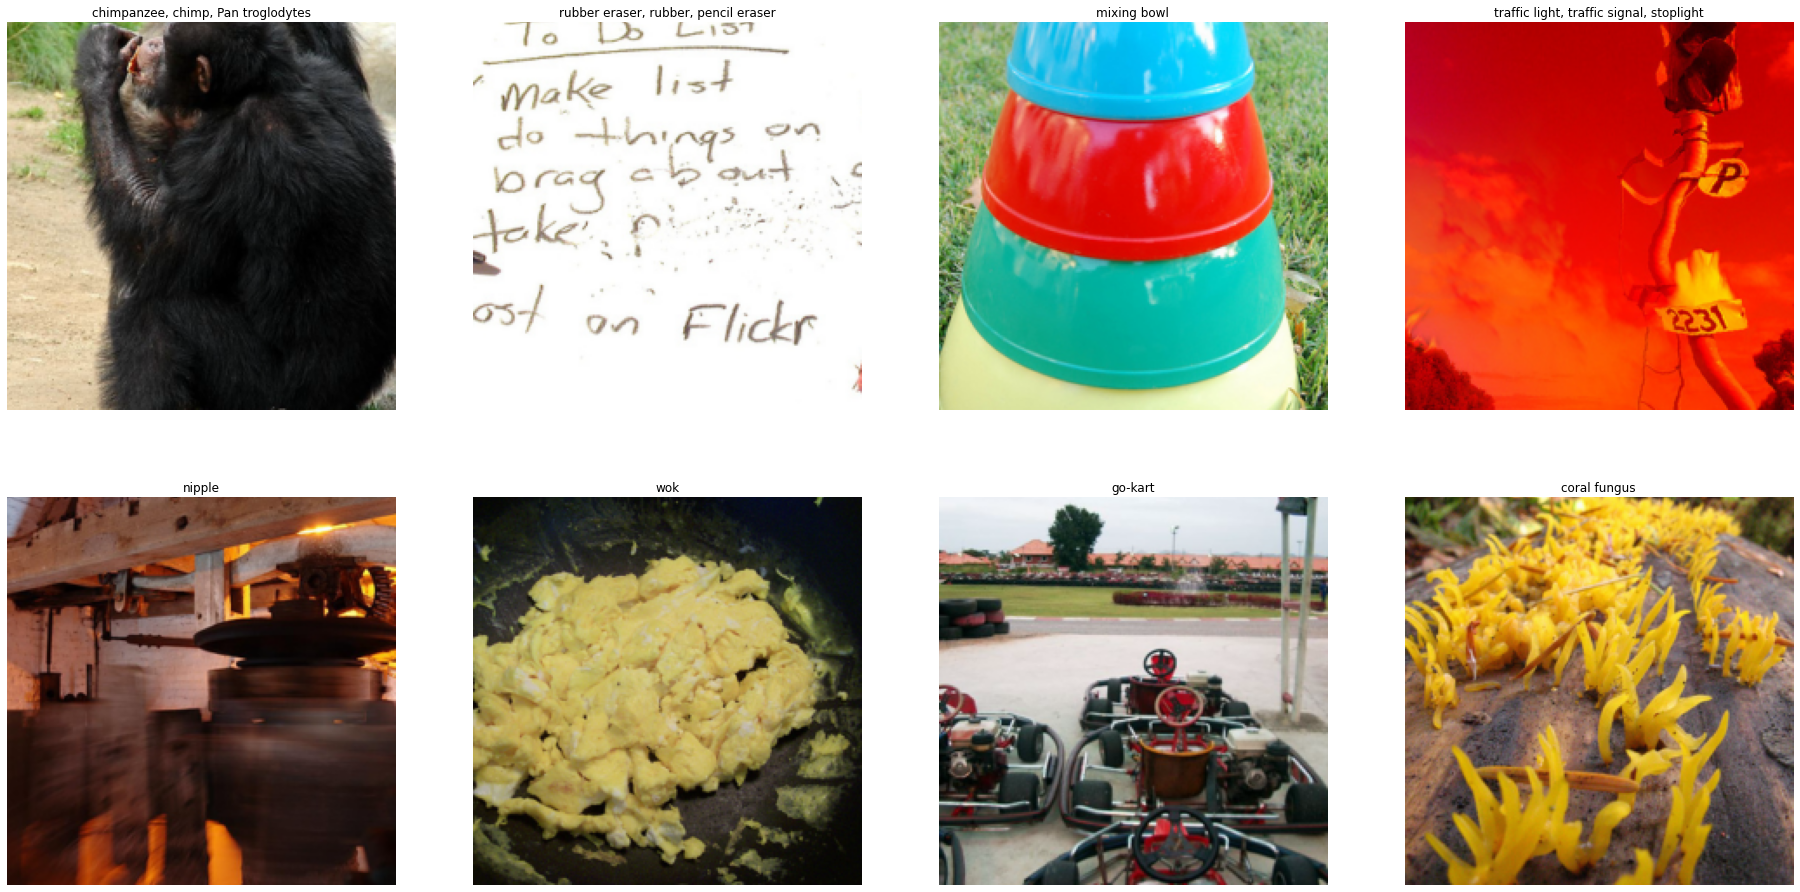

In [9]:
images, labels = pipe_out
show_images(images.as_cpu(), labels)

In [10]:
from timeit import default_timer as timer

test_batch_size = 256

def speedtest(pipeclass, batch, n_threads):
    pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 20
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print("Speed: {} imgs/s".format((n_test * batch)/t))

In [ ]:
test_batch_size = 256

speedtest(HybridPipeline, test_batch_size, 6)